#Importing necessary libraries

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

#Reading dataframe

Data set Link: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

In [40]:
# Load and preprocess data
data_frame = pd.read_csv("/content/spam.csv", encoding="latin-1")
data_frame = data_frame.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data_frame.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#Finding and replacing unique classes in the dataset

In [41]:
data_frame["v1"] = (data_frame["v1"] == 'spam').astype(int)
data_frame["v1"].unique()
data_frame.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


#Spliting dataset

In [43]:
# Split the data into train, validation, and test sets
X = data_frame['v2'].values  # Text data
y = data_frame['v1'].values  # Labels

# First split: separate test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: separate train (60%) and validation (20%) from remaining data
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  # 0.25 of 80% = 20% of total
)
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 3342 samples
Validation set: 1115 samples
Test set: 1115 samples


In [51]:
# Create and fit tokenizer
tokenizer = Tokenizer(num_words=50000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=200, truncating='post')
X_val_pad   = pad_sequences(X_val_seq, maxlen=200, truncating='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=200, truncating='post')

print(f"\nPreprocessed data shapes:")
print(f"X_train_pad: {X_train_pad.shape}")
print(f"X_val_pad: {X_val_pad.shape}")
print(f"X_test_pad: {X_test_pad.shape}")



Preprocessed data shapes:
X_train_pad: (3342, 200)
X_val_pad: (1115, 200)
X_test_pad: (1115, 200)


#Model Sturucture/Sequeunce

In [52]:
# Build the LSTM model
model = Sequential([
    Embedding(50000, 64, input_length=200),
    LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    LSTM(32, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("\nModel Architecture:")
model.summary()



Model Architecture:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [53]:
print("\nTraining the model...")
history = model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    verbose=1
)


Training the model...
Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 69s 572ms/step - accuracy: 0.8144 - loss: 0.4736 - val_accuracy: 0.9731 - val_loss: 0.1019
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 76s 513ms/step - accuracy: 0.9866 - loss: 0.0784 - val_accuracy: 0.9803 - val_loss: 0.0810
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 84s 533ms/step - accuracy: 0.9930 - loss: 0.0388 - val_accuracy: 0.9839 - val_loss: 0.0827
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 54s 514ms/step - accuracy: 0.9957 - loss: 0.0177 - val_accuracy: 0.9839 - val_loss: 0.0815
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 82s 512ms/step - accuracy: 0.9987 - loss: 0.0063 - val_accuracy: 0.9848 - val_loss: 0.0886
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 86s 552ms/step - accuracy: 0.9990 - loss: 0.0074 - val_accuracy: 0.9830 - val_loss: 0.1080
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 60s 572ms/step - accuracy: 0.9996 - loss: 0.0057 - val_accuracy: 0.9821 - val_loss: 0.1118
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 77s 524ms/step - acc

#Plotting loss and accuracy

In [54]:
def plot_loss(history):
  plt.plot(history.history["loss"], label="loss")
  plt.plot(history.history["val_loss"], label="val_loss")
  plt.xlabel("Epochs")
  plt.ylabel("Binary crossentropy")
  plt.legend()
  plt.grid(True)
  plt.show()

def plot_accuracy(history):
  plt.plot(history.history["accuracy"], label="accuracy")
  plt.plot(history.history["val_accuracy"], label="val_accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.grid(True)
  plt.show()

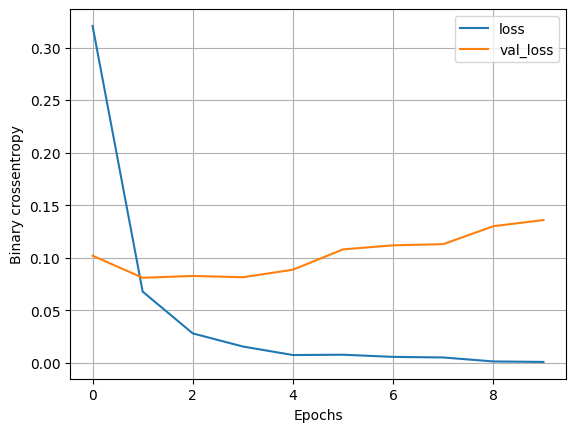

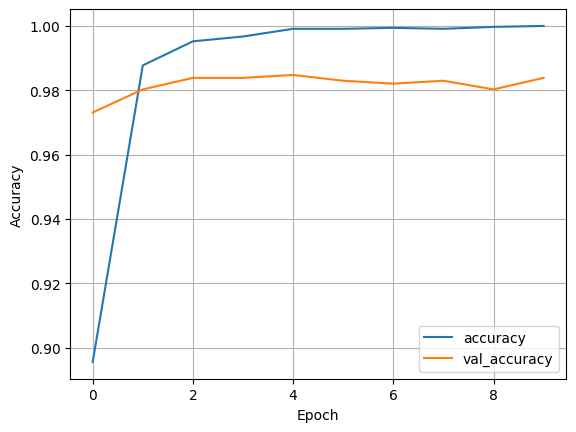

In [55]:
plot_loss(history)
plot_accuracy(history)

# Make predictions on test set

In [56]:
y_pred_proba = model.predict(X_test_pad)
y_pred = (y_pred_proba > 0.5).astype(int)

35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step


#Prinitng accuracy

In [58]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       966
        Spam       0.98      0.91      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115


Confusion Matrix:
[[963   3]
 [ 14 135]]
